# Approximate Inference

In machine learning inference is the task of combinging our assumptions with the observed data. More specifically, if we have a set of observed data $\mathbf{Y}$, parameterized by a variable $\theta$, then we wish to obtain the posterior,

\begin{equation}
p(\mathbf{\theta} \mid \mathbf{Y}) = \frac{p(\mathbf{Y} \mid \mathbf{\theta}) p(\mathbf{\theta})}{p(\mathbf{Y})}.
\end{equation}

The denominator is known as the marginal likelihood (or evidence) and represents the probability of the observed data when all of the assumptions have been propogated through and integrated out,

\begin{equation}
p(\mathbf{Y}) = \int p(\mathbf{Y}, \mathbf{\theta}) d\theta.
\end{equation}

Sometimes this integral is intractable (computationally or analytically) so we cannot exploit conjugacy to avoid it's calculation. For this reason we have to make approximations to this integral.

This can be demonstarted through image restoration, the process of cleaning up images that have been corrupted by noise. 

# Image Restoration
Image restoration of binary images.

## The Model
Our task here is to build a model of images, in specific of binary or black-and-white images. Images are normally represented as a grid of pixels $y_i$ however the images we observe are noisy and rather will be a realisation of an underlying latent pixel representation $x_i$. Lets say that white is encoded by $x_i = 1$ and black with $x_i = −1$ and that the grey-scale values that we observed $y_i \in (0, 1)$. We will write our likelihood on this form,

\begin{equation}
p(\mathbf{y} \mid \mathbf{x}) = \frac{1}{Z_1} \prod_{i=1}^{N} e^{L_i(x_i)},
\end{equation}

where $L_i(x_i)$ is a function which generates a large value if $x_i$ is likely to have generated $y_i$ and $Z_1$ is a factor that ensures that $p(\mathbf{y} \mid \mathbf{x})$ is a distribution. We have further assumed that the pixels in the image are conditionally independent given the latent variables x.

## Setup
The following python packages are required:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
%matplotlib inline

The functions defined below are used to read in an image and add Gaussian noise and/or salt and pepper noise.

In [3]:
def add_gaussian_noise(im, prop, varSigma):
    """
     Adds Gaussian noise to an image
    :param im: input image
    :param prop: proportion of pixels to have noise added
    :param varSigma: variance of Gaussian noise
    :return: original image with added Gaussian noise
    """
    N = int(np.round(np.prod(im.shape)*prop))
    
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2 = np.float64(im2)
    im2[index] += e[index]
    
    return im2

def add_saltnpeppar_noise(im, prop):
    """
    Adds salt and pepper noise (flipped pixels) to an image
    :param im: input image
    :param prop: proportion of pixels to have noise added
    :return: im2: original image with added salt and pepper noise
    """
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]

    return im2

def setup_image(img_path, prop, varSigma, level):
    """
    Reads an image and creates a noisy version (y) as well as it's corresponding latent representation (x)
    :param img_path: path to input image
    :param prop: proportion of pixels to have noise added
    :param varSigma: variance of gaussian noise
    :param level: level of noise (gaussian, saltnpepper, both)
    :return:    orgImg: original grayscale image
                yImg: noisy image (y)
                xImg: latent image (x)
    """
    # read image and convert to greyscale
    img = imread(img_path)
    orgImg = np.asarray(img)/255
   
    # add noise to image to create y (noisy image)
    if level == 1:  # gaussian noise only
        yImg = add_gaussian_noise(orgImg, prop, varSigma)  # noisy image
    elif level == 2:  # salt and pepper noise only
        yImg = add_saltnpeppar_noise(orgImg, prop)  # noisy image
    elif level == 3:  # both gaussian + salt and pepper noise
        yImg = add_gaussian_noise(orgImg, prop, varSigma)
        yImg = add_saltnpeppar_noise(yImg, prop)
    
#     yImg[yImg>1] = 1
#     yImg[yImg<0] = 0
    
    # initialise x (latent variable)  [-1, +1]
    mean = np.mean(yImg)
    # TODO: Should latent representation be initialised as zeros or set to 1 or -1 using mean of y
    xImg = np.zeros(yImg.shape)
    xImg[yImg < mean] = -1
    xImg[yImg >= mean] = 1
    
    return orgImg, yImg, xImg
    

Some helper functions are defined below. The "neighbours" function is used by the prior to determine all of the neighbours of a given pixel $x_i$ from the latent image $x$.

In [4]:
def neighbours(i, j, M, N, size=4):
    """
    Finds the neighbours of a node (i, j)
    :param i: y position
    :param j: x position
    :param M: height of image
    :param N: width of image
    :param size: 4 doesn't include diagonals, 8 does include diagonals
    :return: array containing coordinates of neighbours
    """
    if size==4:
        if (i==0 and j==0):
             n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n

    if size==8:
        if (i==0 and j==0):
             n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1), (1,N-2)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0), (M-2,1)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1), (M-2,N-2)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j), (1,j+1), (1,j-1)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1,j+1)]

        return np.array(n)

def percent_correct(xImg, orgImg):
    """
    Calculates the percentage of pixels that are correct in xImg relative to orgImg
    :param xImg: latent image (x)
    :param orgImg: original (noise free) image
    :return: percentage of pixels in xImg that are the same as in orgImg
    """
    return float(np.sum(xImg == orgImg)) / orgImg.size * 100.00

def plot_comparison(orgImg, xImg, yImg):
    """
    Plot original image, noisy image and de-noised image
    :param orgImg: original image
    :param xImg: latent image (x)
    :param yImg: noisy image (y)
    """
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(orgImg, cmap='gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(yImg, cmap='gray')
    axarr[1].set_title('Noisy Image')
    axarr[2].imshow(xImg, cmap='gray')
    axarr[2].set_title('De-noised Image')

    plt.show()

def plot_iteration(xImg, i):
    """
    Plots de-noised image at iteration i
    :param xImg: latent image (x)
    :param i: number of iterations
    """
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(xImg, cmap='gray')
    ax.set_title('De-noised Image (%d iterations)' % (i+1), fontsize=16)
    plt.show()

The model that we will use is referred to as a Markov Random Field with an Ising prior. The functions for the likelihood and prior are defined below:

In [5]:
def E0(y, x, beta):
    """
    Calculates the likelihhod p(y|x)
    :param y: noisy image value (y_i)
    :param x: latent image value (x_i)
    :param beta: likelihood weight parameter
    :return: likelihhod p(y|x)
    """
    return beta * ((2*y - 1) * x)

# def Z(y, beta):
#     return likelihood2(E0(y, 1, beta)) + likelihood2(E0(y, -1, beta))

def likelihood(y, x, beta):
    """
    Calculates the likelihhod p(y|x)
    :param y: noisy image value (y_i)
    :param x: latent image value (x_i)
    :param beta: likelihood weight parameter
    :return: likelihhod p(y|x)
    """
    return np.exp(beta * ((2*y - 1) * x))

# def likelihood2(E0):
#     """
#     Calculates the likelihhod p(y|x)
#     :param y: noisy image value (y_i)
#     :param x: latent image value (x_i)
#     :param beta: likelihood weight parameter
#     :return: likelihhod p(y|x)
#     """
#     return np.exp(E0)
    
def prior(x_i, x, i, j, w):
    """
    Calcualtes Ising prior p(x) (assuming pixel depends on its neighbouring pixels)
    :param x_i: value of x at index i (x[i,j])
    :param x: latent variable x
    :param i: y position
    :param j: x position
    :param w: prior weight parameter
    :retur: prior p(x)
    """
    n = neighbours(i, j, x.shape[0], x.shape[1], size=8)
    return np.exp(np.sum(w * x_i * x[n[:, 0], n[:, 1]]))
#     prior = 0
#     for n in neighbours1:
#         prior += w * x_i * x[n[0],n[1]]
#     return np.exp(prior)

In [6]:
def de_noise(img_path, algorithm, noise, consts, max_iter, plot_all_flag):
    """
    De-noises image using the algorithm specified
    :param img_path: path to the image
    :param algorithm: function object containing de-noising algorithm e.g. gibbs, icm etc
    :param noise: [prop, varSigma, level]
    :param consts: weight parameters for prior and likelihood respectively [w, beta]
    :param max_iter: max number of full image scans
    :param plot_all_flag: if plot_all_flag=1 then plots each iteration
    """
    # setup image
    orgImg, yImg, xImg = setup_image(img_path, noise[0], noise[1], noise[2])

    print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
    
    algorithm(orgImg, yImg, xImg, consts, max_iter, plot_all_flag)
    
    print("\nFinished de-noising\n")
    print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
    # Plot original image, noisy image and de-noised image
    plot_comparison(orgImg, xImg, yImg)

## Iterative Conditional Models (ICM)

The functions to implement ICM are as follows:

In [7]:
def icm(orgImg, yImg, xImg, consts, max_iter, plot_all_flag=0):
    """
    Implements Iterative Conditional Modes for Ising Model (image de-noising) (a simple coordinate-wise gradient approach)
    :param orgImg: original image
    :param yImg: noisy image (y)
    :param xImg: latent image (x)
    :param consts: weight parameters for prior and likelihood respectively [w, beta]
    :param max_iter: max number of full image scans
    :param plot_all_flag: 1=plot de-noised image at every full image scan iteration
    """
    for i in range(max_iter):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):
                
                joint_dist_pos = likelihood(yImg[x, y], 1, consts[1]) * prior(1, xImg, x, y, consts[0])
                joint_dist_neg = likelihood(yImg[x, y], -1, consts[1]) * prior(-1, xImg, x, y, consts[0])

                if joint_dist_pos > joint_dist_neg:
                    xImg[x, y] = 1
                else:
                    xImg[x, y] = -1

        print("Iteration: ", i + 1)
        print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
        
        if plot_all_flag == 1:
            plot_iteration(xImg, i)

The ICM algorithm only requires 2-3 passes to obtain good results. A convergence criteria was implemented that converges when the total energy of the image does not decrease after a full pass off the image.

## Stochastic Inference
#TODO: Add text here

### Basic Sampling
#TODO: Add text here

### Markov Chain Monte Carlo
#TODO: Add text here

### Gibbs Sampling
#TODO: Add text here

In [8]:
def gibbs(orgImg, yImg, xImg, consts, max_iter, plot_all_flag=0):
    """
    Implements Gibbs sampling for Ising Model (image de-noising)
    :param orgImg: original image
    :param yImg: noisy image (y)
    :param xImg: latent image (x)
    :param consts: weight parameters for prior and likelihood respectively [w, beta]
    :param max_iter: max number of full image scans
    :param plot_all_flag: 1=plot de-noised image at every full image scan iteration
    """
    for i in range(max_iter):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):
                
                px1 = likelihood(yImg[x, y], 1, consts[1]) * prior(1, xImg, x, y, consts[0])
                px2 = likelihood(yImg[x, y], -1, consts[1]) * prior(-1, xImg, x, y, consts[0])
                cond_dist = px1 / (px1 + px2)

                t = np.random.uniform(0, 1)
            #     t = np.random.uniform(0.4, 0.6)

                if cond_dist > t:
                    xImg[x, y] = 1
                else:
                    xImg[x, y] = -1

        print("Iteration: ", i + 1)
        print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
        
        if plot_all_flag == 1:
            plot_iteration(xImg, i)

In [9]:
def gibbs_random(orgImg, yImg, xImg, consts, max_iter, plot_all_flag=0):
    """
    Implements Gibbs with random sampling for Ising Model (image de-noising)
    :param orgImg: original image
    :param yImg: noisy image (y)
    :param xImg: latent image (x)
    :param consts: weight parameters for prior and likelihood respectively [w, beta]
    :param max_iter: max number of full image scans
    :param plot_all_flag: 1=plot de-noised image at every full image scan iteration
    """
    N = xImg.shape[0] * xImg.shape[1]  # calculate number of pixels
    for i in range(max_iter):
        for a in range(1, N):
            x = np.random.randint(0, orgImg.shape[0])  # pick random x
            y = np.random.randint(0, orgImg.shape[1])  # pick random y
                
            px1 = likelihood(yImg[x, y], 1, consts[1]) * prior(1, xImg, x, y, consts[0])
            px2 = likelihood(yImg[x, y], -1, consts[1]) * prior(-1, xImg, x, y, consts[0])
            cond_dist = px1 / (px1 + px2)

            t = np.random.uniform(0, 1)
        #     t = np.random.uniform(0.4, 0.6)

            if cond_dist > t:
                xImg[x, y] = 1
            else:
                xImg[x, y] = -1

        print("Iteration: ", i + 1)
        print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
        
        if plot_all_flag == 1:
            plot_iteration(xImg, i)

## Determinisitic Inference

### Variational Bayes

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def var_bayes(orgImg, yImg, xImg, consts, max_iter, plot_all_flag=0):
    """
    Implementation of variational Bayes for Ising Model
    :param orgImg: original image
    :param yImg: noisy image (y)
    :param xImg: latent image (x)
    :param consts: weight parameters for prior and likelihood respectively [w, beta]
    :param max_iter: max number of full image scans
    :param plot_all_flag: 1=plot de-noised image at every full image scan iteration
    """
    mu = np.zeros([xImg.shape[0], xImg.shape[1]])  # initialise variational distribution

    for i in range(max_iter):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):

                neighbour = neighbours(x, y, xImg.shape[0], xImg.shape[1], size=8) # get neighbours of current pixel
                m_i = consts[0] * np.sum(mu[neighbour[:, 0], neighbour[:, 1]])  # m_i = sum (w_ij * mu_ij)
                a_i = m_i + 0.5 * (E0(yImg[x, y], 1, consts[1]) - E0(yImg[x, y], -1, consts[1]))
                mu[x, y] = np.tanh(a_i)

                # calculate posterior for pixel i
                q_x = sigmoid(2*a_i)

#         print("Iteration: ", i + 1)
        xImg[mu<0] = -1
        xImg[mu>=0] = 1
#         print("Percent of pixels correct: ", round(percent_correct(xImg, orgImg), 2), "%")
        if plot_all_flag == 1:
            plot_iteration(xImg, i)

The code below iterates through different noise levels, applies each algorithm and display's their output.


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=0.20, varSigma=0.10, noise=Gaussian + Salt & Pepper


-----Beginning ICM De-Noising-----

Percent of pixels correct:  54.9 %
Iteration:  1
Percent of pixels correct:  62.79 %
Iteration:  2
Percent of pixels correct:  63.59 %
Iteration:  3
Percent of pixels correct:  63.76 %
Iteration:  4
Percent of pixels correct:  63.84 %

Finished de-noising

Percent of pixels correct:  63.84 %


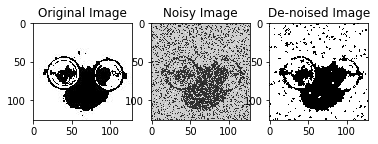


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  54.96 %
Iteration:  1
Percent of pixels correct:  62.07 %
Iteration:  2
Percent of pixels correct:  63.7 %
Iteration:  3
Percent of pixels correct:  64.35 %
Iteration:  4
Percent of pixels correct:  64.43 %

Finished de-noising

Percent of pixels correct:  64.43 %


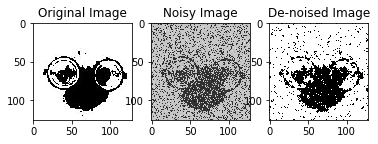


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  54.98 %
Iteration:  1
Percent of pixels correct:  59.37 %
Iteration:  2
Percent of pixels correct:  61.22 %
Iteration:  3
Percent of pixels correct:  62.56 %
Iteration:  4
Percent of pixels correct:  63.28 %

Finished de-noising

Percent of pixels correct:  63.28 %


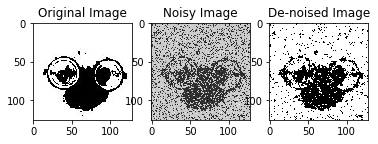


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  54.94 %

Finished de-noising

Percent of pixels correct:  67.19 %


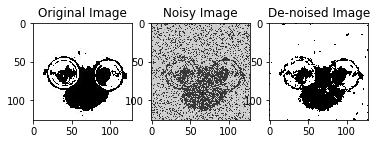


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=0.20, varSigma=0.10, noise=Gaussian + Salt & Pepper


-----Beginning ICM De-Noising-----

Percent of pixels correct:  54.76 %
Iteration:  1
Percent of pixels correct:  62.37 %
Iteration:  2
Percent of pixels correct:  63.31 %
Iteration:  3
Percent of pixels correct:  63.42 %
Iteration:  4
Percent of pixels correct:  63.46 %

Finished de-noising

Percent of pixels correct:  63.46 %


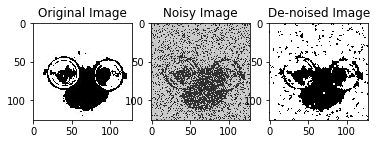


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  54.81 %
Iteration:  1
Percent of pixels correct:  61.87 %
Iteration:  2
Percent of pixels correct:  63.6 %
Iteration:  3
Percent of pixels correct:  64.19 %
Iteration:  4
Percent of pixels correct:  64.53 %

Finished de-noising

Percent of pixels correct:  64.53 %


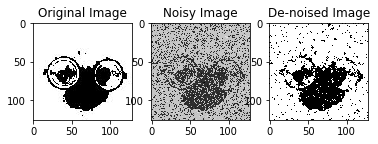


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  54.76 %
Iteration:  1
Percent of pixels correct:  59.47 %
Iteration:  2
Percent of pixels correct:  61.52 %
Iteration:  3
Percent of pixels correct:  62.7 %
Iteration:  4
Percent of pixels correct:  63.45 %

Finished de-noising

Percent of pixels correct:  63.45 %


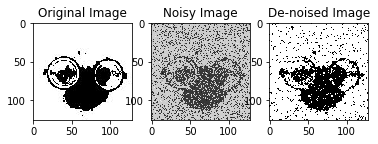


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  54.92 %

Finished de-noising

Percent of pixels correct:  66.8 %


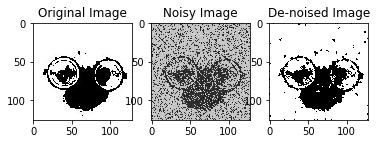


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=1.00, varSigma=0.10, noise=Gaussian


-----Beginning ICM De-Noising-----

Percent of pixels correct:  67.75 %
Iteration:  1
Percent of pixels correct:  68.5 %
Iteration:  2
Percent of pixels correct:  68.5 %
Iteration:  3
Percent of pixels correct:  68.5 %
Iteration:  4
Percent of pixels correct:  68.5 %

Finished de-noising

Percent of pixels correct:  68.5 %


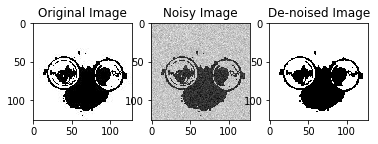


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  67.65 %
Iteration:  1
Percent of pixels correct:  68.06 %
Iteration:  2
Percent of pixels correct:  67.95 %
Iteration:  3
Percent of pixels correct:  68.16 %
Iteration:  4
Percent of pixels correct:  68.12 %

Finished de-noising

Percent of pixels correct:  68.12 %


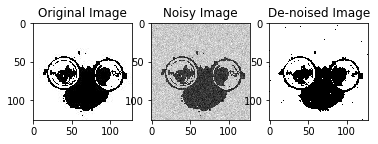


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  67.78 %
Iteration:  1
Percent of pixels correct:  68.0 %
Iteration:  2
Percent of pixels correct:  67.99 %
Iteration:  3
Percent of pixels correct:  67.96 %
Iteration:  4
Percent of pixels correct:  68.0 %

Finished de-noising

Percent of pixels correct:  68.0 %


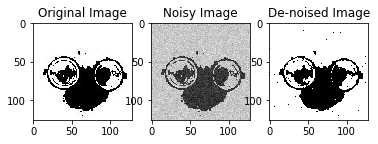


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  67.71 %

Finished de-noising

Percent of pixels correct:  68.46 %


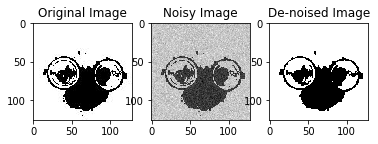


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=1.00, varSigma=3.20, noise=Gaussian


-----Beginning ICM De-Noising-----

Percent of pixels correct:  36.25 %
Iteration:  1
Percent of pixels correct:  39.32 %
Iteration:  2
Percent of pixels correct:  39.57 %
Iteration:  3
Percent of pixels correct:  39.59 %
Iteration:  4
Percent of pixels correct:  39.59 %

Finished de-noising

Percent of pixels correct:  39.59 %


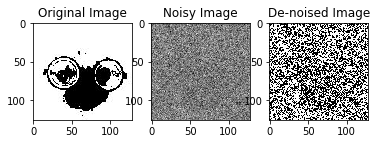


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  36.3 %
Iteration:  1
Percent of pixels correct:  39.18 %
Iteration:  2
Percent of pixels correct:  39.6 %
Iteration:  3
Percent of pixels correct:  39.81 %
Iteration:  4
Percent of pixels correct:  39.75 %

Finished de-noising

Percent of pixels correct:  39.75 %


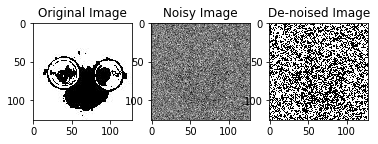


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  35.91 %
Iteration:  1
Percent of pixels correct:  37.49 %
Iteration:  2
Percent of pixels correct:  38.16 %
Iteration:  3
Percent of pixels correct:  38.71 %
Iteration:  4
Percent of pixels correct:  38.76 %

Finished de-noising

Percent of pixels correct:  38.76 %


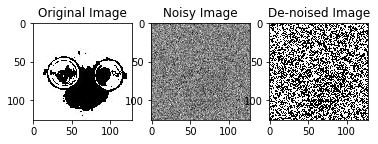


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  36.01 %

Finished de-noising

Percent of pixels correct:  40.2 %


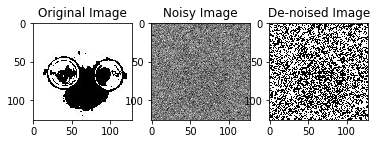


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=0.50, varSigma=3.20, noise=Gaussian


-----Beginning ICM De-Noising-----

Percent of pixels correct:  52.46 %
Iteration:  1
Percent of pixels correct:  55.12 %
Iteration:  2
Percent of pixels correct:  55.22 %
Iteration:  3
Percent of pixels correct:  55.21 %
Iteration:  4
Percent of pixels correct:  55.21 %

Finished de-noising

Percent of pixels correct:  55.21 %


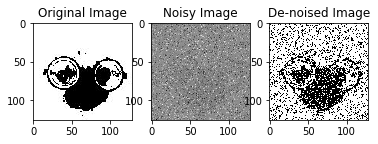


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  52.75 %
Iteration:  1
Percent of pixels correct:  54.7 %
Iteration:  2
Percent of pixels correct:  54.61 %
Iteration:  3
Percent of pixels correct:  54.7 %
Iteration:  4
Percent of pixels correct:  54.85 %

Finished de-noising

Percent of pixels correct:  54.85 %


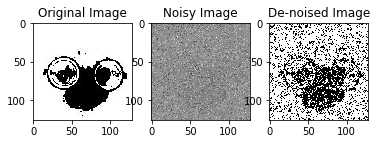


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  52.39 %
Iteration:  1
Percent of pixels correct:  53.55 %
Iteration:  2
Percent of pixels correct:  54.09 %
Iteration:  3
Percent of pixels correct:  54.23 %
Iteration:  4
Percent of pixels correct:  54.35 %

Finished de-noising

Percent of pixels correct:  54.35 %


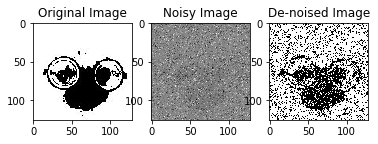


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  52.26 %

Finished de-noising

Percent of pixels correct:  55.33 %


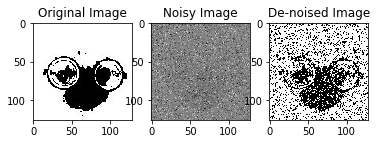


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=0.20, varSigma=0.00, noise=Salt & Pepper


-----Beginning ICM De-Noising-----

Percent of pixels correct:  54.9 %
Iteration:  1
Percent of pixels correct:  62.34 %
Iteration:  2
Percent of pixels correct:  63.07 %
Iteration:  3
Percent of pixels correct:  63.2 %
Iteration:  4
Percent of pixels correct:  63.27 %

Finished de-noising

Percent of pixels correct:  63.27 %


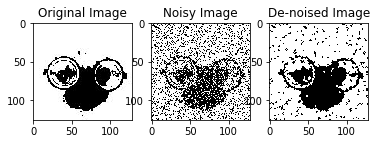


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  55.03 %
Iteration:  1
Percent of pixels correct:  62.33 %
Iteration:  2
Percent of pixels correct:  63.94 %
Iteration:  3
Percent of pixels correct:  64.48 %
Iteration:  4
Percent of pixels correct:  64.46 %

Finished de-noising

Percent of pixels correct:  64.46 %


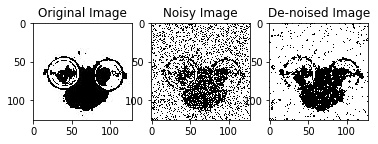


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  54.99 %
Iteration:  1
Percent of pixels correct:  59.54 %
Iteration:  2
Percent of pixels correct:  62.1 %
Iteration:  3
Percent of pixels correct:  63.28 %
Iteration:  4
Percent of pixels correct:  64.22 %

Finished de-noising

Percent of pixels correct:  64.22 %


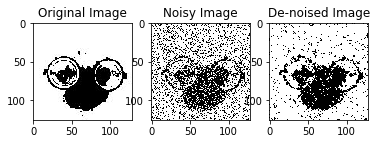


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  54.99 %

Finished de-noising

Percent of pixels correct:  67.01 %


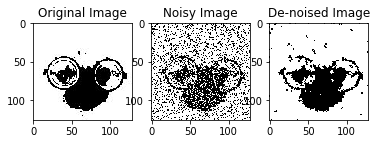


-----Beginning Variational Bayes De-Noising-----

Noise Level: prop=0.50, varSigma=0.00, noise=Salt & Pepper


-----Beginning ICM De-Noising-----

Percent of pixels correct:  34.09 %
Iteration:  1
Percent of pixels correct:  28.08 %
Iteration:  2
Percent of pixels correct:  26.36 %
Iteration:  3
Percent of pixels correct:  25.54 %
Iteration:  4
Percent of pixels correct:  25.14 %

Finished de-noising

Percent of pixels correct:  25.14 %


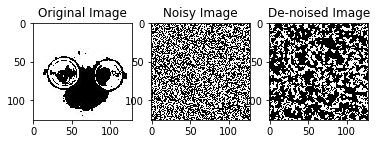


-----Beginning Gibbs De-Noising-----

Percent of pixels correct:  34.17 %
Iteration:  1
Percent of pixels correct:  34.13 %
Iteration:  2
Percent of pixels correct:  34.0 %
Iteration:  3
Percent of pixels correct:  34.31 %
Iteration:  4
Percent of pixels correct:  34.06 %

Finished de-noising

Percent of pixels correct:  34.06 %


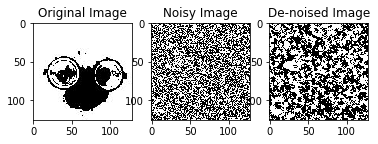


-----Beginning Gibbs Random De-Noising-----

Percent of pixels correct:  34.29 %
Iteration:  1
Percent of pixels correct:  33.77 %
Iteration:  2
Percent of pixels correct:  33.88 %
Iteration:  3
Percent of pixels correct:  33.9 %
Iteration:  4
Percent of pixels correct:  34.13 %

Finished de-noising

Percent of pixels correct:  34.13 %


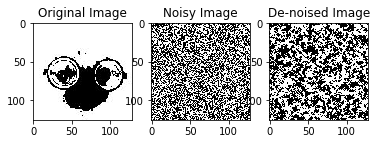


-----Beginning Variational Bayes De-Noising-----

Percent of pixels correct:  34.49 %

Finished de-noising

Percent of pixels correct:  35.11 %


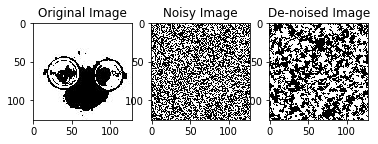

In [11]:
max_iter = 4 # max number of iterations
plot_all_flag = 0 # if 1 then will plot de-noised image (x) after every iteration
img_path = '../data/pug-glasses.jpg'

algorithm_names = ["ICM", "Gibbs", "Gibbs Random", "Variational Bayes"]
algorithm = algorithm_names[3]
algorithms = {"ICM": icm, "Gibbs": gibbs, "Gibbs Random": gibbs_random, "Variational Bayes": var_bayes}

# create different noise levels for testing - n x [prop, varSigma, Level] 
noise = [[0.2, 0.1, 3], [0.2, 0.1, 3], [1.0, 0.1, 1], [1.0, 3.2, 1], [0.5, 3.2, 1], [0.2, 0, 2], [0.5, 0, 2]]

# set weight parameters for prior and likelihood respectively [w, beta]
consts = [1/4, 1]


# run de-noising for different noise levels
for n in noise:
    print("\n-----Beginning %s De-Noising-----\n" % algorithm)
    if n[2] == 1:
        noiseLevel = "Gaussian"
    elif n[2] == 2:
        noiseLevel = "Salt & Pepper"
    elif n[2] == 3:
        noiseLevel = "Gaussian + Salt & Pepper"
#     print("Noise Level: prop=%.2f, varSigma=%.2f, noise=%s\n" % (n[0], n[1], noiseLevel))
#     de_noise(img_path, algorithms[algorithm], n, consts, max_iter, plot_all_flag)
    
#     orgImg, yImg = setup_image(img, n)

    x = {}
    for name, alg in algorithms.items():
        print("\n-----Beginning %s De-Noising-----\n" % name)
        de_noise(img_path, algorithms[name], n, consts, max_iter, plot_all_flag)
        

In [ ]:
max_iter = 4 # max number of iterations
plot_all_flag = 0 # if 1 then will plot de-noised image (x) after every iteration
img_path = '../data/pug-glasses.jpg'

algorithm_names = ["ICM", "Gibbs", "Gibbs Random", "Variational Bayes"]
algorithm = algorithm_names[3]
algorithms = {"ICM": icm, "Gibbs": gibbs, "Gibbs Random": gibbs_random, "Variational Bayes": var_bayes}

# create different noise levels for testing - n x [prop, varSigma, Level] 
noise = [[0.2, 0.1, 3], [0.2, 0.1, 3], [1.0, 0.1, 1], [1.0, 3.2, 1], [0.5, 3.2, 1], [0.2, 0, 2], [0.5, 0, 2]]

# set weight parameters for prior and likelihood respectively [w, beta]
consts = [1/4, 1]


# run de-noising for different noise levels
for n in noise:
    print("\n-----Beginning %s De-Noising-----\n" % algorithm)
    if n[2] == 1:
        noiseLevel = "Gaussian"
    elif n[2] == 2:
        noiseLevel = "Salt & Pepper"
    elif n[2] == 3:
        noiseLevel = "Gaussian + Salt & Pepper"
    print("Noise Level: prop=%.2f, varSigma=%.2f, noise=%s\n" % (n[0], n[1], noiseLevel))
    de_noise(img_path, algorithms[algorithm], n, consts, max_iter, plot_all_flag)